# Title: Classification of subcellular protein locations in microscopic images using random forest machine learning: comparison of different feature extraction methods

### Group members: Zeng Fung Liew, Yixing Lu

# Background:
- __Data__: The dataset is obtained from https://kodu.ut.ee/~leopoldp/2016_DeepYeast/. It is a set of single cell images extracted by Pärnamaa et. al (2017) from the original image library described in Chong et. al (2015). The microscopic images were taken in two channels: green and red. GFP (green fluroescent protein) labeled the protein of interest and was detected in the green channel, while RFP (red fluorecent protein) outlined the cell contour and was detected in the red channel. 
- __Objectives__: 
  * Classify subcellular locations of the protein of interest, i.e. GFP, with comparable accuracy as original paper.
  * Compare different feature extraction m


## Pipeline:
1. Fine the region of interest (ROI) based on red and green channels
2. Feature extraction 
  * Shift invariant feature transform (SIFT)
  * Local discriminant basis (LDB)
  * Stationary wavelet transform (SWT) - Discrete cosine transform (DCT)
  * Haralick texture features based on GLM
  * Scattering transform
3. Model fitting
  * Random forest (Grid Search CV through hyperparameters)
  * Possible work: stacking ensemble / voting system of the 5 models above

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# switch working directory to working directory of main repository 
os.chdir("./..")

In [2]:
from codes import *

reorganize_data()

Data already reorganized!


# Load Data

In [3]:
(X_train, y_train), (X_valid, y_valid), (X_test, y_test) = load_data()

In [4]:
# example images
example_idx = {}
labels = np.unique(y_train)
for i in labels:
    example_idx[i] = np.where(y_train==i)[0][50]  # tinker with the last index value to experiment with different images

In [5]:
# function to plot example images
def plot_images(data, idx, channels):
    mapping = {0: "cell periphery", 1: "cytoplasm", 2: "endosome", 3: "er", 4: "golgi",
               5: "mitochondrion", 6: "nuclear periphery", 7: "nucleolus", 8: "nucleus",
               9: "peroxisome", 10: "spindle pole", 11: "vacuole"}
    fig, ax = plt.subplots(2,6, figsize=(12,5))
    if channels == 3:
        ax[0,0].imshow(cv2.cvtColor(data[idx[0]],cv2.COLOR_BGR2RGB))
        ax[0,0].set_title(mapping[0])
        ax[0,1].imshow(cv2.cvtColor(data[idx[1]],cv2.COLOR_BGR2RGB))
        ax[0,1].set_title(mapping[1])
        ax[0,2].imshow(cv2.cvtColor(data[idx[2]],cv2.COLOR_BGR2RGB))
        ax[0,2].set_title(mapping[2])
        ax[0,3].imshow(cv2.cvtColor(data[idx[3]],cv2.COLOR_BGR2RGB))
        ax[0,3].set_title(mapping[3])
        ax[0,4].imshow(cv2.cvtColor(data[idx[4]],cv2.COLOR_BGR2RGB))
        ax[0,4].set_title(mapping[4])
        ax[0,5].imshow(cv2.cvtColor(data[idx[5]],cv2.COLOR_BGR2RGB))
        ax[0,5].set_title(mapping[5])
        ax[1,0].imshow(cv2.cvtColor(data[idx[6]],cv2.COLOR_BGR2RGB))
        ax[1,0].set_title(mapping[6])
        ax[1,1].imshow(cv2.cvtColor(data[idx[7]],cv2.COLOR_BGR2RGB))
        ax[1,1].set_title(mapping[7])
        ax[1,2].imshow(cv2.cvtColor(data[idx[8]],cv2.COLOR_BGR2RGB))
        ax[1,2].set_title(mapping[8])
        ax[1,3].imshow(cv2.cvtColor(data[idx[9]],cv2.COLOR_BGR2RGB))
        ax[1,3].set_title(mapping[9])
        ax[1,4].imshow(cv2.cvtColor(data[idx[10]],cv2.COLOR_BGR2RGB))
        ax[1,4].set_title(mapping[10])
        ax[1,5].imshow(cv2.cvtColor(data[idx[11]],cv2.COLOR_BGR2RGB))
        ax[1,5].set_title(mapping[11])
    elif channels == 1:
        ax[0,0].imshow(data[idx[0]], cmap="gray")
        ax[0,0].set_title(mapping[0])
        ax[0,1].imshow(data[idx[1]], cmap="gray")
        ax[0,1].set_title(mapping[1])
        ax[0,2].imshow(data[idx[2]], cmap="gray")
        ax[0,2].set_title(mapping[2])
        ax[0,3].imshow(data[idx[3]], cmap="gray")
        ax[0,3].set_title(mapping[3])
        ax[0,4].imshow(data[idx[4]], cmap="gray")
        ax[0,4].set_title(mapping[4])
        ax[0,5].imshow(data[idx[5]], cmap="gray")
        ax[0,5].set_title(mapping[5])
        ax[1,0].imshow(data[idx[6]], cmap="gray")
        ax[1,0].set_title(mapping[6])
        ax[1,1].imshow(data[idx[7]], cmap="gray")
        ax[1,1].set_title(mapping[7])
        ax[1,2].imshow(data[idx[8]], cmap="gray")
        ax[1,2].set_title(mapping[8])
        ax[1,3].imshow(data[idx[9]], cmap="gray")
        ax[1,3].set_title(mapping[9])
        ax[1,4].imshow(data[idx[10]], cmap="gray")
        ax[1,4].set_title(mapping[10])
        ax[1,5].imshow(data[idx[11]], cmap="gray")
        ax[1,5].set_title(mapping[11])
    else:
        print("Number of channels should be either 1 or 3")

Here's how the original data looks like.

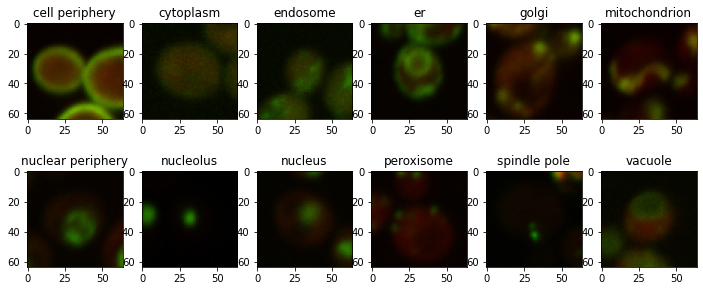

In [16]:
plot_images(X_train, example_idx, 3)

# Preprocessing of images

## Split channels

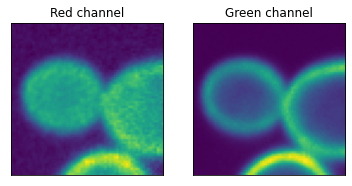

In [17]:
im = X_train[example_idx[0]]
im_green = cv2.split(im)[1]
im_red = cv2.split(im)[2]
plt.subplot(1,2,1), plt.imshow(im_red)
plt.title("Red channel"), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2), plt.imshow(im_green)
plt.title("Green channel"), plt.xticks([]), plt.yticks([])
plt.show()

## Binary mask on red channel

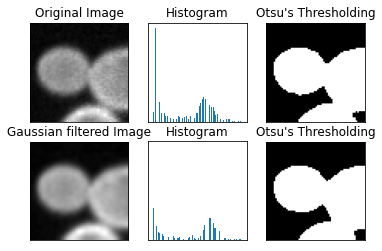

In [18]:
## create binary images from red channel
# Otsu thresholding
ret1, thr1  = cv2.threshold(im_red, 0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# gaussian filter followed by Otsu thresholding
im_blur = cv2.GaussianBlur(im_red,(5,5),0)
ret2, thr2 = cv2.threshold(im_blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# plot both images and their histograms
images = [im_red, 0, thr1,
          im_blur, 0, thr2]
titles = ['Original Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]
for i in range(2):
    plt.subplot(2,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(2,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(2,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

## Define ROI on Green Channel and normalize

In [4]:
# image preprocessing step
image_processor = image_preprocessing()

# preprocess train data
X_raw_g_train,X_raw_r_train = image_processor.split_channels(X_train)
X_mask_train,_ = image_processor.ROI()
Xn_train = image_processor.image_normalize(option="ROI")

# preprocess valid data
X_raw_g_valid,X_raw_r_valid = image_processor.split_channels(X_valid)
X_mask_valid,_ = image_processor.ROI()
Xn_valid = image_processor.image_normalize(option="ROI")

# preprocess test data
X_raw_g_test,X_raw_r_test = image_processor.split_channels(X_test)
X_mask_test,_ = image_processor.ROI()
Xn_test = image_processor.image_normalize(option="ROI")

In [5]:
# remove images without detectable ROI
def remove_noncell(mask,src):
    """
    Remove from dataset the samples where no ROI is detected. 
    These samples are non-cells mistakenly recognized as cells in previous segmentation.
    @param mask: a list of masks constructed from source images.
    @para src: a list of source images used to consturct masks or the corresponding y variables. Must be the same length as mask.
    """
    update = src.copy()
    count=0
    for (i,img) in enumerate(mask):
        if len(np.unique(img)) != 2:
            update.pop(i-count)
            count += 1
    return update

In [6]:
# updated dataset with non-cells removed
# preprocess train data
X_raw_g_train_new = remove_noncell(X_mask_train,X_raw_g_train)
X_mask_train_new = remove_noncell(X_mask_train,X_mask_train)
Xn_train_new = remove_noncell(X_mask_train,Xn_train)
y_train_new = remove_noncell(X_mask_train,y_train.tolist())
y_train_new = np.array(y_train_new)

# preprocess valid data
X_raw_g_valid_new = remove_noncell(X_mask_valid,X_raw_g_valid)
X_mask_valid_new = remove_noncell(X_mask_valid,X_mask_valid)
Xn_valid_new = remove_noncell(X_mask_valid,Xn_valid)
y_valid_new = remove_noncell(X_mask_valid,y_valid.tolist())
y_valid_new = np.array(y_valid_new)

# preprocess test data
X_raw_g_test_new = remove_noncell(X_mask_test,X_raw_g_test)
X_mask_test_new = remove_noncell(X_mask_test,X_mask_test)
Xn_test_new = remove_noncell(X_mask_test,Xn_test)
y_test_new = remove_noncell(X_mask_test,y_test.tolist())
y_test_new = np.array(y_test_new)

In [34]:
import pandas as pd
size = np.array([[len(Xn_train_new),len(Xn_valid_new),len(Xn_test_new)],[len(Xn_train),len(Xn_valid),len(Xn_test)]])
pd.DataFrame(size,index=np.array(['Updated','Original']),columns = np.array(['Train',"Valid",'Test']))

,Train,Valid,Test
Updated,64938,12493,12495
Original,65000,12500,12500


Here's how the normalized data look like.

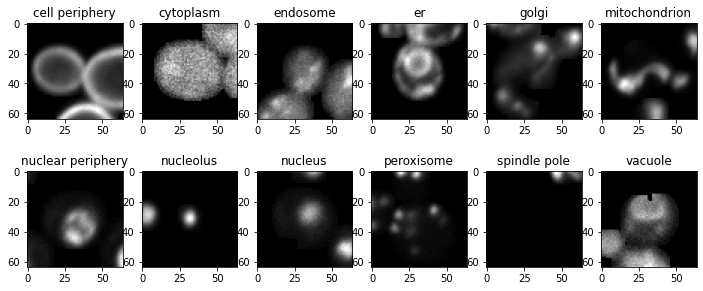

In [35]:
plot_images(Xn_train, example_idx, 1)

# Feature Extraction

## Shift-Invariant Feature Transform (SIFT) for Bag of Feature (BoF)

The Shift Invariant Feature Transform (SIFT) is a feature extraction technique for images developed by David Lowe in 1999. SIFT has many general uses, such as pattern matching, object detection, video tracking etc. 

**SIFT for Image Classification**

For the purpose of image classification, incorporating SIFT into our model means that we follow the steps below:

1. **Using SIFT to extract features from each image**.
2. **Using an unsupervised learning algorithm such as K-Means, cluster the features into $k$ clusters**.
3. **Using the clustered features, form bar charts of represent the features (aka. Bag-of-Features(BoF))**.
4. **Fitting a classifier such as SVM to the BOW model**.

For the prediction step, we have the following pipeline:

1. **Using SIFT to extract features from each image**.
2. **Group the features to the nearest cluster centers calculated from Step 2 of the training phase**.
3. **Using the clustered features, form bar charts of represent the features (aka. Bag-of-Features(BoF))**.
4. **Make class predictions using the trained classifier**.


**Why SIFT?**

It is important to understand why or why not to use SIFT. The pros and cons of this algorithm is as follows:  

**Pros:**
* Scale and rotation invariant. This is particularly important in a cell classification since we don't want translations and rotated version of the same cell to be classified differently.
* High recall rates and accuracy

**Cons:**
* Computationally expensive. This may pose a problem considering our dataset has 90,000 images. This issue may not be as severe of an issue in our case since the dimension of our images are all quite small ($64 \times 64$).
* Due to its computation complexity, this is not a good choice if one's goal is to use this model for real-time prediction.

In [10]:
sift = cv2.xfeatures2d.SIFT_create(nfeatures=0, contrastThreshold=0, edgeThreshold=0)
kp = sift.detect(Xn_train_new, None)
kp, des = sift.compute(Xn_train_new, kp)
# stack all descriptors
des_all = np.empty(shape=(0,128), dtype=np.float64)
for (i, de) in enumerate(des):
    if de is None:
        print("Image {0} has no keypoints.".format(i))
        pass
    elif de.ndim == 1:
        des_all = np.append(des_all, [de], axis=0)
    else:
        des_all = np.append(des_all, de, axis=0)

Image 6045 has no keypoints.
Image 8460 has no keypoints.
Image 8678 has no keypoints.
Image 10101 has no keypoints.
Image 10229 has no keypoints.
Image 11132 has no keypoints.
Image 11172 has no keypoints.
Image 11483 has no keypoints.
Image 12150 has no keypoints.
Image 14742 has no keypoints.
Image 16168 has no keypoints.
Image 18373 has no keypoints.
Image 18643 has no keypoints.
Image 19349 has no keypoints.
Image 22501 has no keypoints.
Image 23048 has no keypoints.
Image 26237 has no keypoints.
Image 27091 has no keypoints.
Image 27255 has no keypoints.
Image 32098 has no keypoints.
Image 33037 has no keypoints.
Image 33271 has no keypoints.
Image 35211 has no keypoints.
Image 35470 has no keypoints.
Image 35911 has no keypoints.
Image 36198 has no keypoints.
Image 36253 has no keypoints.
Image 36868 has no keypoints.
Image 37413 has no keypoints.
Image 37445 has no keypoints.
Image 37578 has no keypoints.
Image 37810 has no keypoints.
Image 38734 has no keypoints.
Image 39734 h

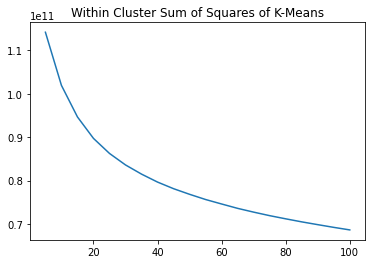

In [11]:
from sklearn.cluster import KMeans

wcss = []
for i in range(5,101, 5):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(des_all)
    wcss += [kmeans.inertia_]
    
plt.plot(np.arange(5,101, 5), wcss)
plt.title("Within Cluster Sum of Squares of K-Means");

While it is not entirely clear what number of clusters is the best from the plot above, it seems that selecting 40 clusters is a good way to go based on the elbow rule.

In [7]:
sift_ = SIFT_FeatureExtractor(
    sift_nfeatures=0, 
    sift_nOctaveLayers=3,
    sift_contrastThreshold=0,
    sift_edgeThreshold=0,
    sift_sigma=1.6,
    kmeans_nclusters=40
)
Xsift_train = sift_.fit_transform(Xn_train_new)
Xsift_valid = sift_.transform(Xn_valid_new)
Xsift_test = sift_.transform(Xn_test_new)

In [8]:
np.savez("sift_data", 
         X_train=Xsift_train, y_train=y_train_new,
         X_valid=Xsift_valid, y_valid=y_valid_new, 
         X_test=Xsift_test, y_test=y_test_new)

## Local Discriminant Basis (LDB) using Wavelets Transform

Local Discriminant Basis is a feature extraction technique developed by N. Saito and R. Coifman in 1995. This algorithm follows the following basic steps:

1. Decompose a set of multi-class signals using wavelet packet decomposition. A wavelet packet decomposition decomposes a signal into multiple nodes which resembles a binary tree.
2. Based on the decomposed wavelet coefficients, build an energy map based on time-frequency or probability density.
3. Using the energy map, compute the discriminant measure and select a basis tree that best discriminates the different classes of signals.
4. Based on the selected basis tree, extract the corresponding wavelet coefficients for each signal.
5. Compute the discriminant power of each coefficient index. Select the top k set of coefficients to be used as features to be passed onto a classifier such as Linear Discriminant Analysis (LDA) and Classification and Regression Trees (CART).

A more in-depth tutorial can be found in the Pluto notebook [here](https://github.com/ShozenD/LDBExperiments). For more information on LDB, please refer to the original paper "Local Discriminant Basis and their Applications" by Saito and Coifman [here](https://www.math.ucdavis.edu/~saito/publications/saito_ldb_jmiv.pdf).

**Pros:**  
- Specifically searches for the coefficients that distinguish between classes.
- There are many ways for computing the energy maps and discriminant measures. One may play around with the different discriminant measures to find the best set of coefficients in the basis dictionary for classification purposes.

**Cons:**  
- Currently, there aren't any softwares that run this algorithm. LDB used to be implemented in the older versions of C++ and Matlab, but with recent updates this require significant amount of effort and time to get things running. The algorithm implemented in Julia is still an ongoing project.
- 2D-Wavelet Transform is not yet available in Julia as it is still a new language. The current workaround is to reshape our images to 1D-arrays, but this inevitably results in the loss of some information.
- LDB utilizes the regular wavelet transforms which, due to its non-redundant nature, is not shift-invariant unlike the other methods discussed. One way to reduce this problem, one may turn to using random "spin-cycles" to generate more training images, ie. we randomly generate training images that are shifted 5 pixels to the left, or 10 pixels downwards etc. Since this dataset is already very large and conducting LDB on the original training set already takes a couple of hours, we decided to skip this step and list it as a caveat.

In [19]:
from julia import Main

Main.using("Wavelets")
Main.using("WaveletsExt")

ldb_ = LDB_FeatureExtractor(
    wt=Main.wavelet(Main.WT.coif4), 
    max_dec_level=8,
    dm=Main.SymmetricRelativeEntropy(),
    en=Main.ProbabilityDensity(),
    dp=Main.RobustFishersClassSeparability(),
)
Xldb_train = ldb_.fit_transform(Xn_train_new, y_train_new)

View the discriminant power plot, and use the elbow rule to determine the number of features to be used.

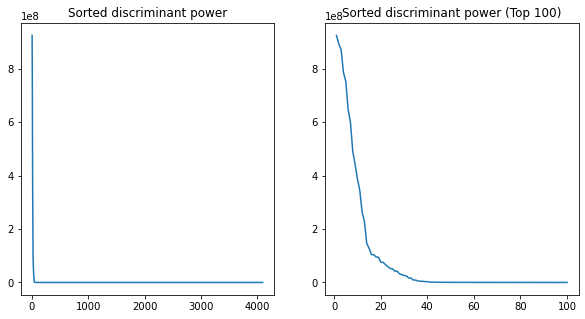

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.plot(np.arange(1,64**2+1), ldb_.DP[ldb_.order])
ax1.set_title("Sorted discriminant power")

ax2.plot(np.arange(1,101), ldb_.DP[ldb_.order[:100]])
ax2.set_title("Sorted discriminant power (Top 100)");

We decided that 30 is a fair amount of features to be extracted. So here we go...

In [21]:
Xldb_train = ldb_.change_nfeatures(Xldb_train, 30)
Xldb_valid = ldb_.transform(Xn_valid_new)
Xldb_test = ldb_.transform(Xn_test_new)

This is how the images look after we compute the inverse transform based on that 30 features.

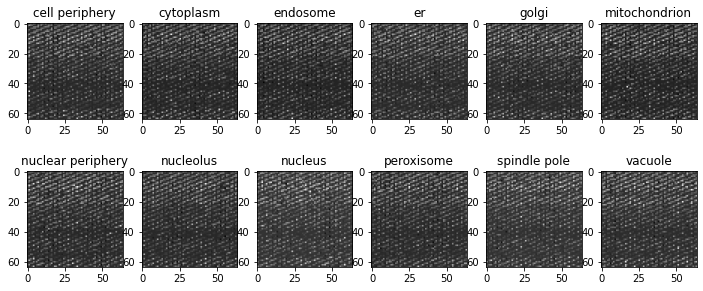

In [22]:
Xldbi_train = ldb_.inverse_transform(Xldb_train)
plot_images(Xldbi_train, example_idx, 1)

In [23]:
np.savez("ldb_data", X_train=Xldb_train, y_train=y_train_new, X_valid=Xldb_valid, y_valid=y_valid_new, X_test=Xldb_test, y_test=y_test_new)

Clearly, the images do not look as distinct as we hoped, but this is due to the fact that these inverse images are only generated by 30 out of 4096 features. In other words, what's used by the computer to distinguish the classes is different from what humans see as a whole.

## Stationary Wavelet Transform (SWT) Based Feature Extractor

**Note:** This method is referenced from Qayyum et al.'s "Facial Expression Recognition Using Stationary Wavelet Transform Features".

Another method of feature extraction is using stationary wavelet transforms (SWT). Unlike its wavelet transform counterpart, SWT does not perform downsampling, ie. the decomposed images have the exact same shape as the original signal. Therefore, the SWT is considered as a redundant transform. 

Since our images are decomposed into Approximation coefficients and Horizontal, Vertical and Diagonal coefficients, the total number of coefficients of the decomposed images is 4 times the number of the original image. The number of coefficients increases by a multiple of 4 if we decide to further decompose our image into more levels. For the sake of speed and efficiency, we will not pursue any decomposition beyond the first level.

**SWT for Image Classification**

For the purpose of image classification, incorporating SWT into our model means that we follow the steps below:

1. **1 level of SWT decomposition of each image.** As mentioned previously, we will only compute one level of decomposition for each image. This will lead to us obtaining the approximate (`cA`), horizontal detail (`cH`), vertical detail (`cV`), and diagonal detail (`cD`) coefficients.
2. **Compute the Discrete Cosine Transform (DCT) on each set of coefficients.** To reduce the size of feature coefficients, $8 \times 8$ block DCT is applied to the `cH`, `cV`, and `cD` coefficients only. Based on Qayyum et al's paper, the DCT applied to each block is calculated as
$$
X(u,v) = \frac{C(u) C(v)}{4} \sum_{m=0}{7} \sum_{n=0}{7} x[m,n] \cos(\frac{(2m+1)u\pi}{16}) \cos(\frac{(2n+1)v\pi}{16})
$$
where
$$
C(u) = \begin{cases} \frac{1}{\sqrt{2}}, & u=0 \\ 1, & 1\leq u \leq 7 \end{cases}, C(v) = \begin{cases} \frac{1}{\sqrt{2}}, & v=0 \\ 1, & 1\leq v \leq 7 \end{cases}
$$
This can be done using the `scipy.fftpack.dct` function and setting `type=2` and `norm="ortho"`.
3. **Reshape the results from step 2 into 1D vectors.**
4. **Fit the result from step 4 into a classifier.**

For the prediction step, we have the following pipeline:

1. **1 level of SWT decomposition of each image.**
2. **Compute the Discrete Cosine Transform (DCT) on each set of coefficients.**
3. **Reshape the results from step 2 into 1D vectors.**
4. **Fit the result from step 4 into a classifier.**

**Pros:**

* SWT is shift invariant, which can be important when it comes to feature extraction in cell images.

**Cons:**

* Due to its redundant nature, the SWT is significantly less efficient that the DWT, and this may pose a problem with the large number of images that we have.

#### Stationary Wavelet Transform

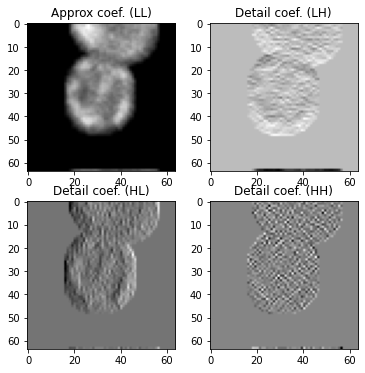

In [31]:
import pywt

# play around with the images and wavelets to observe the effect of SWT
# also try out with contrast-adjusted images
im = Xn_train[example_idx[0]]
wt = "Haar"

cA, (cH, cV, cD) = pywt.swt2(im, wt, 1, 0, trim_approx=True)

fig, ax = plt.subplots(2,2, figsize=(6,6))
ax[0,0].imshow(cA, cmap="gray")
ax[0,0].set_title("Approx coef. (LL)")
ax[0,1].imshow(cH, cmap="gray")
ax[0,1].set_title("Detail coef. (LH)")
ax[1,0].imshow(cV, cmap="gray")
ax[1,0].set_title("Detail coef. (HL)")
ax[1,1].imshow(cD, cmap="gray")
ax[1,1].set_title("Detail coef. (HH)");

#### Discrete Cosine Transform

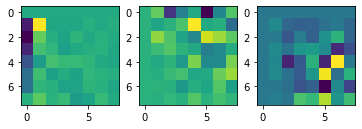

In [32]:
from scipy.fftpack import dct

result = []
for mat in [cH, cV, cD]:
    dmat = dct(dct(mat, 2, axis=0, norm="ortho"), 2, axis=1, norm="ortho")
    result += [dmat[::8, ::8]]

# plotting heatmap of results from DCT
fig, ax = plt.subplots(1,3)
ax[0].imshow(result[0])
ax[1].imshow(result[1])
ax[2].imshow(result[2])

In [41]:
swt_ = SWT_FeatureExtractor(wt="coif4")
Xswt_train = swt_.fit_transform(Xn_train_new)
Xswt_valid = swt_.fit_transform(Xn_valid_new)
Xswt_test = swt_.fit_transform(Xn_test_new)

In [42]:
np.savez("swt_data", 
         X_train=Xswt_train, y_train=y_train_new, 
         X_valid=Xswt_valid, y_valid=y_valid_new, 
         X_test=Xswt_test, y_test=y_test_new)

## Haralick texture features based on GLCM (gray level co-occurrence matrix)

**What is texure?** <br>
Texture describes the spatial distribution of intensity in an image, indicating the consistency of patterns and/or colors. <br>
**What is gray level co-occurrence matrix?** <br>
In a gray-scale image I, co-occurrence matrix is a matrix containing information about how often pairs of pixel values co-occur based on a pre-defined offset.
- An offset ($\Delta x$, $\Delta y$) is a position relation between two pixels. There are four different directions of  adjacency of two pixel values and the unit apart in that direction can be specified by a scale parameter: 
    * top-to-bottom
    * left-to-right
    * top left-to-bottom right
    * top right-to-left bottom

- For each offset, an image I with p different gray-scale values will produce one p*p co-occurrence matrix C. $C_{i,j}$ is the probability that the $i^{th}$ pixel value is found adjacent to the $j^{th}$ pixel value ($p(i,j)$), as defined by the adjacency offset.
- Each image, at a resolution scale, will produce 4 co-occurrence matrix. Haralick (1970) extracted 14 texure features based on these matrices. Details and formulas can be found [here](http://haralick.org/journals/TexturalFeatures.pdf). The last feature is often omitted due to computational instability, thus resulting in 13 features:
    * **AngularSecondMoment**
    * **Contrast**
    * **Correlation**
    * **Variance**:
    * **Inverse Difference Moment**
    * **Sum Average**
    * **Sum Variance**
    * **SumEntropy**
    * **Entropy**
    * **Difference Variance**
    * **Difference Entropy**
    * **InfoMeas1**
    * **InfoMeas2**

In [9]:
# Intensity measurements 
# train
from codes.intensity import *
intensity = IntensityMeasure(mask=X_mask_train_new)
intensity.fit(X_raw_g_train_new)
intensity_features = intensity.transform(X_raw_g_train_new)

In [10]:
# valid
intensity_valid = IntensityMeasure(mask=X_mask_valid_new)
intensity_valid.fit(X_raw_g_valid_new)
intensity_features_valid = intensity_valid.transform(X_raw_g_valid_new)

In [11]:
# test
intensity_test = IntensityMeasure(mask=X_mask_test_new)
intensity_test.fit(X_raw_g_test_new)
intensity_features_test = intensity_test.transform(X_raw_g_test_new)

In [12]:
# Haralick texture features
# train
har = haralick(distance = np.arange(1,7,1),ignore_zeros=False)
har.fit(Xn_train_new)
har_features = har.transform(Xn_train_new)

In [13]:
# valid
har = haralick(distance = np.arange(1,7,1),ignore_zeros=False)
har.fit(Xn_valid_new)
har_features_valid = har.transform(Xn_valid_new)

In [14]:
# test
har.fit(Xn_test_new)
har_features_test = har.transform(Xn_test_new)

## Scattering transform Based Feature Extractor

Scattering transform computes locally translation-invariant image descriptors with a cascade of three operations:
- Wavelet decomposition
- Complex modulus
- Local averaging
It carries the same locally translation-invariant characterization of SIFT but contains more high frequency information. The scattering coefficient from the 1st layer of scattering operator can be computated as:
$$|f*\psi_{j_1,\lambda_1}|*\phi_J,$$ where $f$ is the signal,$\psi_{j_1,\lambda_1}$ is the wavelet at scale $j_1$ and orientation $\lambda_1$, and $\phi_J$ is the averaging filter. <br>
The local averaging will reduce some high frequency information, which can be recovered by convolving $|f*\psi_{j_1,\lambda_1}|$ with another set of wavelets at different scale $j_2$. Thus, the scattering coefficients after kth layer are obtained by performing the following operations iteratively k times:
$$S_{K,J}(f(x))=||f*\psi_{j_1,\lambda_1}|*...*\psi_{j_k,\lambda_k}||*\phi_J, \ j_k<...<j_1<J,(\lambda_,...,\lambda_k) \in \Gamma^k$$
    Extracting image features using scattering transform includes the following steps:
    1. Compute scattering features for a M*N image with pre-specified number of layers (K), and scales (J) and orientations (L) for wavelet decomposition. The kth layer output has a size of $L^k*{J \choose k}$.
    2. For each resulting scattering transformed image with size $(M/(2^J), N/(2^J))$, calculate the mean and variance.
    For a 2-layer scattering transform operator, the resulting feature vector has a size of $2*(1+JL+L^2*J(J-1)/2)$.

In [17]:
from codes.utils import *
from codes.image_preprocessing import *
from codes.scattering_transform import *
from codes.haralick import *
from codes.intensity import *

In [18]:
# train
st = scattering_transform(J=3,shape=(64,64),L=4)
st_features = st.fit_transform(Xn_train_new)

In [19]:
# valid
st_features_valid = st.fit_transform(Xn_valid_new)

In [20]:
# test
st_features_test = st.fit_transform(Xn_test_new)

In [21]:
np.savez("st_data", 
         X_train=st_features, y_train=y_train_new, 
         X_valid=st_features_valid, y_valid=y_valid_new, 
         X_test=st_features_test, y_test=y_test_new)

# Dimension Reduction

## Scattering transform _PCA

In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, FeatureUnion
import matplotlib.transforms as transforms

In [178]:
# PCA pipeline
pca_pipeline = Pipeline(steps=[('standardizer',StandardScaler()),('PCA',PCA())])
st_features_pc = pca_pipeline.fit_transform(st_features)

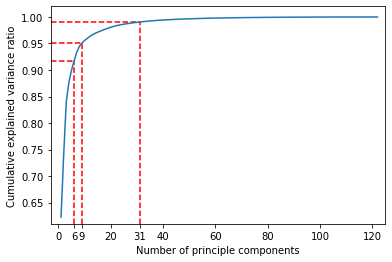

In [179]:
# Explained variance
cum_explained_var=np.cumsum(pca_pipeline['PCA'].explained_variance_ratio_)
plt.plot(range(1,123),cum_explained_var)
plt.ylim((0.61,1.02))
plt.xlim((-3,125))
plt.xlabel("Number of principle components")
plt.ylabel("Cumulative explained variance ratio")
thres1 = np.where(cum_explained_var>=0.9)[0][0]
thres2 = np.where(cum_explained_var>=0.95)[0][0]
thres3 = np.where(cum_explained_var>=0.99)[0][0]
plt.vlines(thres1+1,0.61,cum_explained_var[thres1],linestyles='dashed',colors='red')
plt.vlines(thres2+1,0.61,cum_explained_var[thres2],linestyles='dashed',colors='red')
plt.vlines(thres3+1,0.61,cum_explained_var[thres3],linestyles='dashed',colors='red')
plt.xticks(list([0,20,40,60,80,100,120])+[thres1+1,thres2+1,thres3+1])
plt.hlines(cum_explained_var[thres1],-3,thres1+1,linestyles='dashed',colors='red')
plt.hlines(cum_explained_var[thres2],-3,thres2+1,linestyles='dashed',colors='red')
_=plt.hlines(cum_explained_var[thres3],-3,thres3+1,linestyles='dashed',colors='red')

* First 6,9, and 31 principle components explained for over 90%,95%, and 99% of total variance respectively.

## Intensity and Haralick texture features_PCA

In [15]:
# concatenate intensity and haralick texture features
# train
int_har_features = np.hstack((intensity_features,har_features))
# valid
int_har_features_valid = np.hstack((intensity_features_valid,har_features_valid))
# test
int_har_features_test = np.hstack((intensity_features_test,har_features_test))

In [16]:
np.savez("ih_data", 
         X_train=int_har_features, y_train=y_train_new, 
         X_valid=int_har_features_valid, y_valid=y_valid_new, 
         X_test=int_har_features_test, y_test=y_test_new)

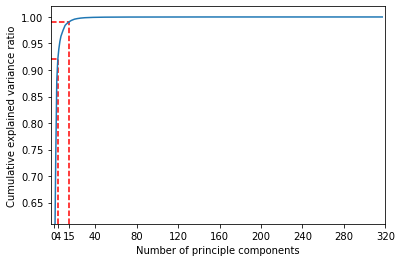

In [192]:
# pca pipeline
int_har_features_pc = pca_pipeline.fit_transform(int_har_features)
# Explained variance
cum_explained_var=np.cumsum(pca_pipeline['PCA'].explained_variance_ratio_)
plt.plot(range(1,318),cum_explained_var)
plt.ylim((0.61,1.02))
plt.xlim((-3,320))
plt.xlabel("Number of principle components")
plt.ylabel("Cumulative explained variance ratio")
thres1 = np.where(cum_explained_var>=0.9)[0][0]
thres2 = np.where(cum_explained_var>=0.99)[0][0]
plt.vlines(thres1+1,0.61,cum_explained_var[thres1],linestyles='dashed',colors='red')
plt.vlines(thres2+1,0.61,cum_explained_var[thres2],linestyles='dashed',colors='red')
plt.xticks(list([0,40,80,120,160,200,240,280,320])+[thres1+1,thres2+1])
plt.hlines(cum_explained_var[thres1],-3,thres1+1,linestyles='dashed',colors='red')
_=plt.hlines(cum_explained_var[thres2],-3,thres2+1,linestyles='dashed',colors='red')

# Model Fitting

## SIFT Based Model

In [18]:
sift_data = np.load("./data/sift_data.npz")

Xsift_train = sift_data["X_train"]
y_train = sift_data["y_train"]
Xsift_valid = sift_data["X_valid"]
y_valid = sift_data["y_valid"]
Xsift_test = sift_data["X_test"]
y_test = sift_data["y_test"]

sift_data.close()

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline([("scale", StandardScaler()), ("pca", PCA(n_components=7))])
pipe.fit(Xsift_train)
Xtsift_train = pipe.transform(Xsift_train)
Xtsift_valid = pipe.transform(Xsift_valid)
Xtsift_test = pipe.transform(Xsift_test)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, PredefinedSplit

rf = RandomForestClassifier(max_samples=0.05)
# hyperparameters
param_grid = {
    "n_estimators": [50, 100, 250, 500, 1000],
    "max_features": ["sqrt", "log2"]
}
# pre-defined validation set
train_valid_X = np.vstack((Xtsift_train, Xtsift_valid))
train_valid_y = np.hstack((y_train, y_valid))
split_index = list(np.repeat(-1, Xtsift_train.shape[0]))+list(np.repeat(0, Xtsift_valid.shape[0]))
pds = PredefinedSplit(test_fold = split_index)
# grid search
sift_gridsearch = GridSearchCV(rf, param_grid=param_grid, cv=pds, scoring='accuracy')
sift_gridsearch.fit(train_valid_X,train_valid_y);

In [21]:
sift_gridsearch.best_params_

{'max_features': 'sqrt', 'n_estimators': 1000}

In [22]:
# Prediction on test set
yhat_train = sift_gridsearch.predict(Xtsift_train)
yhat_valid = sift_gridsearch.predict(Xtsift_valid)
yhat_test = sift_gridsearch.predict(Xtsift_test)

In [23]:
# accuracy and confusion matrix
from sklearn import metrics
accuracy_sift = (yhat_test == y_test).mean()
confusion_sift = metrics.confusion_matrix(y_test, yhat_test, normalize='true')

In [24]:
accuracy_sift

0.503641456582633

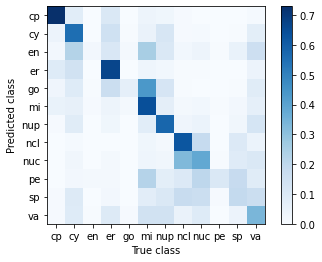

In [25]:
plt.imshow(confusion_sift,cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(12),labels=['cp','cy','en','er','go','mi','nup','ncl','nuc','pe','sp','va'])
plt.yticks(np.arange(12),labels=['cp','cy','en','er','go','mi','nup','ncl','nuc','pe','sp','va'])
plt.xlabel('True class')
_=plt.ylabel('Predicted class')

In [26]:
print("Train data:")
print(metrics.classification_report(y_train, yhat_train))

print("Valid data:")
print(metrics.classification_report(y_valid, yhat_valid))

print("Test data:")
print(metrics.classification_report(y_test, yhat_test))

Train data:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      6922
           1       0.52      0.65      0.58      6929
           2       0.68      0.08      0.14      2692
           3       0.63      0.70      0.67      6181
           4       0.61      0.13      0.22      2770
           5       0.47      0.68      0.55      6539
           6       0.58      0.64      0.61      6660
           7       0.50      0.66      0.57      7010
           8       0.44      0.42      0.43      6438
           9       0.70      0.11      0.20      1682
          10       0.40      0.23      0.29      4705
          11       0.44      0.44      0.44      6410

    accuracy                           0.54     64938
   macro avg       0.57      0.47      0.46     64938
weighted avg       0.56      0.54      0.52     64938

Valid data:
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       961


## LDB Based Model

In [4]:
ldb_data = np.load("./data/ldb_data.npz")

Xldb_train = ldb_data["X_train"]
y_train = ldb_data["y_train"]
Xldb_valid = ldb_data["X_valid"]
y_valid = ldb_data["y_valid"]
Xldb_test = ldb_data["X_test"]
y_test = ldb_data["y_test"]

ldb_data.close()

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline([("scale", StandardScaler()), ("pca", PCA(n_components=7))])
pipe.fit(Xldb_train)
Xtldb_train = pipe.transform(Xldb_train)
Xtldb_valid = pipe.transform(Xldb_valid)
Xtldb_test = pipe.transform(Xldb_test)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, PredefinedSplit

rf = RandomForestClassifier(max_samples=0.05)
# hyperparameters
param_grid = {
    "n_estimators": [50, 100, 250, 500, 1000],
    "max_features": ["sqrt", "log2"]
}
# pre-defined validation set
train_valid_X = np.vstack((Xldb_train, Xldb_valid))
train_valid_y = np.hstack((y_train, y_valid))
split_index = list(np.repeat(-1, Xldb_train.shape[0]))+list(np.repeat(0, Xldb_valid.shape[0]))
pds = PredefinedSplit(test_fold = split_index)
# grid search
ldb_gridsearch = GridSearchCV(rf, param_grid=param_grid, cv=pds, scoring='accuracy')
ldb_gridsearch.fit(train_valid_X,train_valid_y);

In [6]:
ldb_gridsearch.best_params_

{'max_features': 'sqrt', 'n_estimators': 250}

In [8]:
# Prediction on test set
yhat_train = ldb_gridsearch.predict(Xldb_train)
yhat_valid = ldb_gridsearch.predict(Xldb_valid)
yhat_test = ldb_gridsearch.predict(Xldb_test)

In [9]:
# accuracy and confusion matrix
from sklearn import metrics
accuracy_ldb = (yhat_test == y_test).mean()
confusion_ldb = metrics.confusion_matrix(y_test, yhat_test, normalize='true')

In [10]:
accuracy_ldb

0.5192476990796319

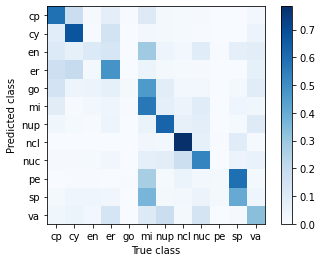

In [11]:
plt.imshow(confusion_ldb,cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(12),labels=['cp','cy','en','er','go','mi','nup','ncl','nuc','pe','sp','va'])
plt.yticks(np.arange(12),labels=['cp','cy','en','er','go','mi','nup','ncl','nuc','pe','sp','va'])
plt.xlabel('True class')
_=plt.ylabel('Predicted class')

In [12]:
print("Train data:")
print(metrics.classification_report(y_train, yhat_train))

print("Valid data:")
print(metrics.classification_report(y_valid, yhat_valid))

print("Test data:")
print(metrics.classification_report(y_test, yhat_test))

Train data:
              precision    recall  f1-score   support

           0       0.68      0.77      0.72      6922
           1       0.67      0.73      0.70      6929
           2       0.52      0.25      0.34      2692
           3       0.53      0.55      0.54      6181
           4       0.74      0.08      0.15      2770
           5       0.41      0.60      0.49      6539
           6       0.66      0.72      0.69      6660
           7       0.71      0.80      0.76      7010
           8       0.59      0.62      0.60      6438
           9       0.78      0.07      0.13      1682
          10       0.62      0.65      0.63      4705
          11       0.54      0.40      0.46      6410

    accuracy                           0.60     64938
   macro avg       0.62      0.52      0.52     64938
weighted avg       0.61      0.60      0.58     64938

Valid data:
              precision    recall  f1-score   support

           0       0.60      0.71      0.65       961


## SWT Based Model

In [34]:
swt_data = np.load("./data/swt_data.npz")

Xswt_train = swt_data["X_train"]
y_train = swt_data["y_train"]
Xswt_valid = swt_data["X_valid"]
y_valid = swt_data["y_valid"]
Xswt_test = swt_data["X_test"]
y_test = swt_data["y_test"]

swt_data.close()

In [105]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline([("scale", StandardScaler()), ("pca", PCA(n_components=150))])
pipe.fit(Xswt_train)
Xtswt_train = pipe.transform(Xswt_train)
Xtswt_valid = pipe.transform(Xswt_valid)
Xtswt_test = pipe.transform(Xswt_test)

In [121]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, PredefinedSplit
import warnings

warnings.filterwarnings(action="ignore")

rf = RandomForestClassifier(max_samples=0.05)
# hyperparameters
param_grid = {
    "n_estimators": [50, 100, 250, 500, 1000],
    "max_features": ["sqrt", "log2"]
}
# pre-defined validation set
train_valid_X = np.vstack((Xtswt_train, Xtswt_valid))
train_valid_y = np.hstack((y_train, y_valid))
split_index = list(np.repeat(-1, Xtswt_train.shape[0]))+list(np.repeat(0, Xtswt_valid.shape[0]))
pds = PredefinedSplit(test_fold = split_index)
# grid search
swt_gridsearch = GridSearchCV(rf, param_grid=param_grid, cv=pds, scoring='accuracy')
swt_gridsearch.fit(train_valid_X,train_valid_y);

In [122]:
swt_gridsearch.best_params_

{'max_features': 'log2', 'n_estimators': 1000}

In [123]:
# Prediction on test set
yhat_train = swt_gridsearch.predict(Xtswt_train)
yhat_valid = swt_gridsearch.predict(Xtswt_valid)
yhat_test = swt_gridsearch.predict(Xtswt_test)

In [124]:
# accuracy and confusion matrix
from sklearn import metrics
accuracy_swt = (yhat_test == y_test).mean()
confusion_swt = metrics.confusion_matrix(y_test, yhat_test, normalize='true')

In [125]:
accuracy_swt

0.3242897158863545

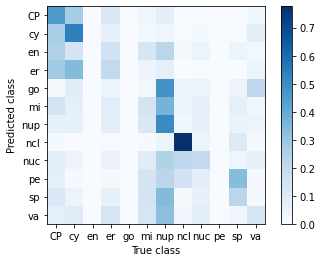

In [126]:
plt.imshow(confusion_swt,cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(12),labels=['CP','cy','en','er','go','mi','nup','ncl','nuc','pe','sp','va'])
plt.yticks(np.arange(12),labels=['CP','cy','en','er','go','mi','nup','ncl','nuc','pe','sp','va'])
plt.xlabel('True class')
_=plt.ylabel('Predicted class')

In [127]:
print("Train data:")
print(metrics.classification_report(y_train, yhat_train))

print("Valid data:")
print(metrics.classification_report(y_valid, yhat_valid))

print("Test data:")
print(metrics.classification_report(y_test, yhat_test))

Train data:
              precision    recall  f1-score   support

           0       0.64      0.92      0.75      6922
           1       0.69      0.91      0.79      6929
           2       1.00      0.02      0.03      2692
           3       0.75      0.76      0.75      6181
           4       1.00      0.00      0.01      2770
           5       0.76      0.65      0.70      6539
           6       0.60      0.89      0.72      6660
           7       0.70      0.91      0.79      7010
           8       0.84      0.68      0.75      6438
           9       0.00      0.00      0.00      1682
          10       0.70      0.64      0.67      4705
          11       0.78      0.68      0.73      6410

    accuracy                           0.70     64938
   macro avg       0.70      0.59      0.56     64938
weighted avg       0.72      0.70      0.66     64938

Valid data:
              precision    recall  f1-score   support

           0       0.60      0.79      0.68       961


## Intensity_Haralick texture features Based Model

In [22]:
from codes.utils import *
from codes.image_preprocessing import *

In [227]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, PredefinedSplit
rf = RandomForestClassifier(max_samples=0.05)
# fit without dimension reduction
# hyperparameters
param_grid = dict(n_estimators=[50,100,250,500,1000],max_features=[10,25,50,100,200])
# pre-defined validation set
train_valid_X = np.vstack((int_har_features,int_har_features_valid))
train_valid_y = np.hstack((y_train_new,y_valid_new))
split_index = list(np.repeat(-1,int_har_features.shape[0]))+list(np.repeat(0,int_har_features_valid.shape[0]))
pds = PredefinedSplit(test_fold = split_index)
# grid search
int_har_gridsearch = GridSearchCV(rf,param_grid = param_grid,cv=pds,scoring='accuracy')
int_har_gridsearch.fit(train_valid_X,train_valid_y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestClassifier(max_samples=0.05),
             param_grid={'max_features': [10, 25, 50, 100, 200],
                         'n_estimators': [50, 100, 250, 500, 1000]},
             scoring='accuracy')

In [268]:
int_har_gridsearch.best_params_

{'max_features': 200, 'n_estimators': 1000}

In [269]:
# Prediction on test set
int_har_test_pred = int_har_gridsearch.predict(int_har_features_test)

In [272]:
# accuracy and confusion matrix
from sklearn import metrics
accuracy_int_har = (int_har_test_pred == y_test_new).mean()
confusion_int_har = metrics.confusion_matrix(y_test_new,int_har_test_pred,normalize='true')

In [271]:
accuracy_int_har

0.6625050020008003

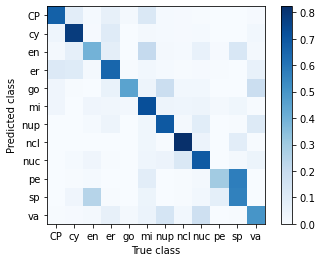

In [287]:
plt.imshow(confusion_int_har,cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(12),labels=['CP','cy','en','er','go','mi','nup','ncl','nuc','pe','sp','va'])
plt.yticks(np.arange(12),labels=['CP','cy','en','er','go','mi','nup','ncl','nuc','pe','sp','va'])
plt.xlabel('True class')
_=plt.ylabel('Predicted class')

In [55]:
# Dimension reduction before fitting model
# load exptracted features to save time
import pandas as pd
har_features = pd.read_csv('local data/haralick_features_train.csv',header=None)
har_features_valid = pd.read_csv('local data/haralick_features_valid.csv',header=None)
har_features_test = pd.read_csv('local data/haralick_features_test.csv',header=None)

In [67]:
# concatenate intensity and haralick texture features
# train
int_har_features = np.hstack((intensity_features,har_features))
# valid
int_har_features_valid = np.hstack((intensity_features_valid,har_features_valid))
# test
int_har_features_test = np.hstack((intensity_features_test,har_features_test))

In [70]:
# Transform data using PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline([("scale", StandardScaler()), ("pca", PCA(n_components=16))])
pipe.fit(int_har_features)
Xtih_train = pipe.transform(int_har_features)
Xtih_valid = pipe.transform(int_har_features_valid)
Xtih_test = pipe.transform(int_har_features_test)

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, PredefinedSplit

rf = RandomForestClassifier(max_samples=0.05)
# hyperparameters
param_grid = {
    "n_estimators": [50, 100, 250, 500, 1000],
    "max_features": ["sqrt", "log2"]
}
# pre-defined validation set
train_valid_X = np.vstack((Xtih_train, Xtih_valid))
train_valid_y = np.hstack((y_train_new, y_valid_new))
split_index = list(np.repeat(-1, Xtih_train.shape[0]))+list(np.repeat(0, Xtih_valid.shape[0]))
pds = PredefinedSplit(test_fold = split_index)
# grid search
ih_gridsearch = GridSearchCV(rf, param_grid=param_grid, cv=pds, scoring='accuracy')
ih_gridsearch.fit(train_valid_X,train_valid_y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestClassifier(max_samples=0.05),
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 100, 250, 500, 1000]},
             scoring='accuracy')

In [74]:
ih_gridsearch.best_params_

{'max_features': 'log2', 'n_estimators': 500}

In [75]:
# Prediction
yhat_train = ih_gridsearch.predict(Xtih_train)
yhat_valid = ih_gridsearch.predict(Xtih_valid)
yhat_test = ih_gridsearch.predict(Xtih_test)
# test accuracy and confusion matrix
from sklearn import metrics
accuracy_ih = (yhat_test == y_test_new).mean()
confusion_ih = metrics.confusion_matrix(y_test_new,yhat_test,normalize='true')
accuracy_ih

0.6550620248099239

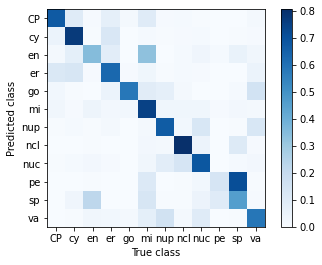

In [76]:
plt.imshow(confusion_ih,cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(12),labels=['CP','cy','en','er','go','mi','nup','ncl','nuc','pe','sp','va'])
plt.yticks(np.arange(12),labels=['CP','cy','en','er','go','mi','nup','ncl','nuc','pe','sp','va'])
plt.xlabel('True class')
_=plt.ylabel('Predicted class')

In [77]:
print("Train data:")
print(metrics.classification_report(y_train_new, yhat_train))

print("Valid data:")
print(metrics.classification_report(y_valid_new, yhat_valid))

print("Test data:")
print(metrics.classification_report(y_test_new, yhat_test))

Train data:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      6922
           1       0.76      0.82      0.79      6929
           2       0.66      0.63      0.65      2692
           3       0.69      0.68      0.68      6181
           4       0.85      0.59      0.70      2770
           5       0.65      0.77      0.71      6539
           6       0.78      0.74      0.76      6660
           7       0.79      0.88      0.83      7010
           8       0.74      0.73      0.74      6438
           9       0.83      0.35      0.49      1682
          10       0.76      0.81      0.78      4705
          11       0.75      0.71      0.73      6410

    accuracy                           0.75     64938
   macro avg       0.76      0.71      0.72     64938
weighted avg       0.76      0.75      0.75     64938

Valid data:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76       961


## Scattering Transform Based Model

In [247]:
# hyperparameters
param_grid = dict(n_estimators=[50,100,250,500,1000],max_features=[10,25,50,75,100])
# pre-defined validation set
train_valid_X_st = np.vstack((st_features,st_features_valid))
split_index = list(np.repeat(-1,st_features.shape[0]))+list(np.repeat(0,st_features_valid.shape[0]))
pds = PredefinedSplit(test_fold = split_index)
# grid search
st_gridsearch = GridSearchCV(rf,param_grid = param_grid,cv=pds,scoring='accuracy')
st_gridsearch.fit(train_valid_X_st,train_valid_y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestClassifier(max_samples=0.05),
             param_grid={'max_features': [10, 25, 50, 75, 100],
                         'n_estimators': [50, 100, 250, 500, 1000]},
             scoring='accuracy')

In [267]:
st_gridsearch.best_params_

{'max_features': 50, 'n_estimators': 1000}

In [249]:
# Prediction on test set
st_test_pred = st_gridsearch.predict(st_features_test)

In [44]:
# accuracy and confusion matrix
from sklearn import metrics
accuracy_st = (st_test_pred == y_test_new).mean()
confusion_st = metrics.confusion_matrix(y_test_new,st_test_pred,normalize='true')

In [45]:
accuracy_st

0.668827531012405

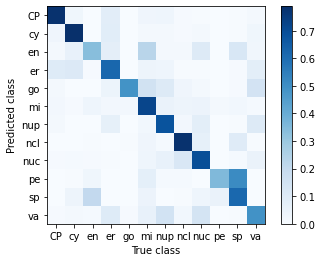

In [288]:
plt.imshow(confusion_st,cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(12),labels=['CP','cy','en','er','go','mi','nup','ncl','nuc','pe','sp','va'])
plt.yticks(np.arange(12),labels=['CP','cy','en','er','go','mi','nup','ncl','nuc','pe','sp','va'])
plt.xlabel('True class')
_=plt.ylabel('Predicted class')

In [10]:
# Dimension reduction before fitting model
# load exptracted features to save time
import pandas as pd
st_features = pd.read_csv('local data/st_features_new_train.csv',header=None)
st_features_valid = pd.read_csv('local data/st_features_valid.csv',header=None)
st_features_test = pd.read_csv('local data/st_features_test.csv',header=None)

In [16]:
# Transform data using PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline([("scale", StandardScaler()), ("pca", PCA(n_components=32))])
pipe.fit(st_features)
Xtst_train = pipe.transform(st_features)
Xtst_valid = pipe.transform(st_features_valid)
Xtst_test = pipe.transform(st_features_test)

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, PredefinedSplit

rf = RandomForestClassifier(max_samples=0.05)
# hyperparameters
param_grid = {
    "n_estimators": [50, 100, 250, 500, 1000],
    "max_features": ["sqrt", "log2"]
}
# pre-defined validation set
train_valid_X = np.vstack((Xtst_train, Xtst_valid))
train_valid_y = np.hstack((y_train_new, y_valid_new))
split_index = list(np.repeat(-1, Xtst_train.shape[0]))+list(np.repeat(0, Xtst_valid.shape[0]))
pds = PredefinedSplit(test_fold = split_index)
# grid search
st_gridsearch = GridSearchCV(rf, param_grid=param_grid, cv=pds, scoring='accuracy')
st_gridsearch.fit(train_valid_X,train_valid_y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestClassifier(max_samples=0.05),
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 100, 250, 500, 1000]},
             scoring='accuracy')

In [30]:
st_gridsearch.best_params_

{'max_features': 'log2', 'n_estimators': 500}

In [49]:
# Prediction on test set
yhat_train = st_gridsearch.predict(Xtst_train)
yhat_valid = st_gridsearch.predict(Xtst_valid)
yhat_test = st_gridsearch.predict(Xtst_test)

In [47]:
# accuracy and confusion matrix
from sklearn import metrics
accuracy_st = (yhat_test == y_test_new).mean()
confusion_st = metrics.confusion_matrix(y_test_new,yhat_test,normalize='true')
accuracy_st

0.693077230892357

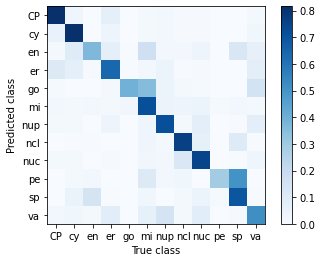

In [34]:
plt.imshow(confusion_st,cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(12),labels=['CP','cy','en','er','go','mi','nup','ncl','nuc','pe','sp','va'])
plt.yticks(np.arange(12),labels=['CP','cy','en','er','go','mi','nup','ncl','nuc','pe','sp','va'])
plt.xlabel('True class')
_=plt.ylabel('Predicted class')

In [50]:
print("Train data:")
print(metrics.classification_report(y_train_new, yhat_train))

print("Valid data:")
print(metrics.classification_report(y_valid_new, yhat_valid))

print("Test data:")
print(metrics.classification_report(y_test_new, yhat_test))

Train data:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      6922
           1       0.79      0.86      0.82      6929
           2       0.75      0.66      0.70      2692
           3       0.75      0.72      0.73      6181
           4       0.88      0.58      0.70      2770
           5       0.67      0.77      0.71      6539
           6       0.79      0.76      0.78      6660
           7       0.79      0.83      0.81      7010
           8       0.74      0.82      0.78      6438
           9       0.81      0.44      0.57      1682
          10       0.77      0.79      0.78      4705
          11       0.71      0.65      0.68      6410

    accuracy                           0.76     64938
   macro avg       0.77      0.73      0.74     64938
weighted avg       0.77      0.76      0.76     64938

Valid data:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       961
